# 1. Visualisation

Dans ce notebook nous avons pour objectif de récupérer les données sur toutes les stations essences en France métropolitaine sur le site data.gouv. 
Ensuite nous analysons ces données pour faire ressortir caractéristiques les plus pertinentes pour la suite de notre projet.

In [62]:
import module_projet as md
import urllib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import cartiflette.s3
from cartiflette.download import get_vectorfile_ign

Nous récupérons désormais les différents fichier contenant les données grâce aux url de téléchargement du site data.gouv pour avoir respectivement un dataframe avec les données mis à jour à chaque instant sur les stations, un avec les données mise à jour quotidiennement, puis pour avoir un geodataframe avec de la même manière les données instantannées et quotdiennes (toutes les fonctions et variables concernant geopandas seront suivi de _g).

In [27]:

urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-instantane-test-ods-copie/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    "data/fichier_inst.csv")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-quotidien-test-ods/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    "data/fichier_quot.csv")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-instantane-test-ods-copie/download/?format=geojson&timezone=Europe/Berlin&lang=fr",
    "data/fichier_inst_g.geojson")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-quotidien-test-ods/download/?format=geojson&timezone=Europe/Berlin&lang=fr",
    "data/fichier_quot_g.geojson")



('data/fichier_quot_g.geojson', <http.client.HTTPMessage at 0x2238a26b520>)

In [30]:
dat_inst = pd.read_csv('data/fichier_inst.csv', sep= ';')
dat_quot =pd.read_csv('data/fichier_quot.csv', sep= ';')
dat_inst_g = gpd.read_file('data/fichier_inst_g.geojson')
data_quot_g = gpd.read_file('data/fichier_quot_g.geojson')

Les dataframes instantannés et quotidiens étant similaire que ce soit avec pandas ou geopandas, on se concentre pour l'instant uniquement sur les dataframes pandas.

In [41]:
dat_inst.groupby('prix_nom').id.count()

prix_nom
E10       6657
E85       3054
GPLc      1358
Gazole    9348
SP95      3725
SP98      7540
Name: id, dtype: int64

In [42]:
dat_quot.groupby('prix_nom').id.count()

prix_nom
E10       14325
E85        5706
GPLc       2245
Gazole    22359
SP95       9243
SP98      16632
Name: id, dtype: int64

On veut nettoyer nos données en gardant selement les colonnes intéréssantes et selon le carburant que notre usager à choisi, nous prendrons ici le Gazole car c'est le carburant le plus présent en France comme on peut le voir. 
On définit donc maintenant des fonctions pour avoir des dataframes gardant uniquement les données qui nous intéressent selon le carburant qui nous intéresse.

In [55]:
def data_carb(df, carb, colonnes_utiles):
    data_1 = df[df.prix_nom == carb]
    d = data_1[colonnes_utiles]
    d.drop_duplicates(keep = 'first', inplace=True) 
    return d

In [81]:
df_visu_inst = data_carb(dat_inst,"Gazole", ['id','adresse', 'ville', 'geom', 'Code Officiel Département',
       'Nom Officiel Département'])
df_visu_quot = data_carb(dat_quot,"Gazole", ['id','adresse', 'ville', 'geom', 'Code Officiel Département',
       'Nom Officiel Département'])

In [82]:
print(df_visu_inst.shape)
print(df_visu_quot.shape)


(9348, 6)
(9325, 6)


On travaillera ensuite uniquement sur le data_frame instantanné puisque les dataframes actuels sont presque identiques. 

On compte par département le nombre de stations essence pour avoir une idée de où l'on trouve le plus de stations en France et en Ile-de-France.

http://files.opendatarchives.fr/professionnels.ign.fr/adminexpress/ADMIN-EXPRESS-COG_3-1__SHP__FRA_L93_2022-04-15.7z
Data have been previously downloaded and are still available in C:\Users\hugol\AppData\Local\Temp/COG-2022


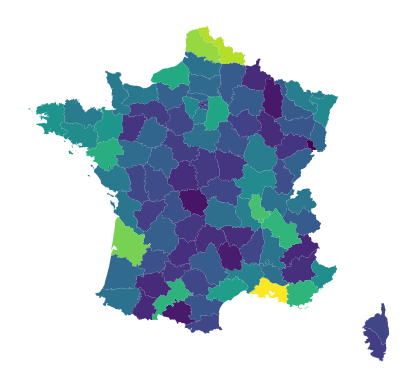

In [128]:
dep = get_vectorfile_ign(
  level = "DEPARTEMENT", field = "metropole",
  source = "COG", provider="opendatarchives")

series = df_visu_inst.groupby('Code Officiel Département').id.count() #series avec le nombre de stations par département

for i in range(len(dep)):
    dep.loc[i, 'count_stations'] = int(series.iloc[dep.INSEE_DEP[i] == series.index]) 
    #on ajoute une colonne avec le nombre de stations en faisant correspondre les départements de dep et de la series
ax = dep.plot(column = "count_stations")
ax.set_axis_off()

Le nombre de stations à l'air d'être repartie assez aléatoirememt, on prendra donc comme adresse de référence celle de l'un des membres du groupe :  1 rue d'Arsonval, Orsay, France.


Pour savoir le nombre de stations que l'on va proposer à l'usager on regarde le nombre de station autour de l'usager en fonction de la distance. 

In [ ]:
def Adresse_to_gps(Adresse) : #Fonction
    geolocator = Nominatim(user_agent="Projet Python")
    location = geolocator.geocode(Adresse)
    return str(str(location.latitude) + ','+ str(location.longitude))

In [152]:
def nb_station(df,Adresse, rayon) : #calcul de nb de station dans un rayon spécifié
    n=0
    position= Adresse_to_gps(Adresse)
    
    A = list(map(float,position.split(',')))
    for station in range(len(df)) : 
        B = list(map(float,df.iloc[station,3].split(',')))
        D=md.distanceGPS(A,B)
        if D<rayon : 
            n=n+1
    return n 

print(nb_station(df_visu_inst, "1 rue d'Arsonval, Orsay, France", 20000))

1


In [153]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(20000, 1000000, 500)
y=[]

for l in range(len(x)) : #prend 7min !
    y.append(nb_station(df_visu_inst, "1 rue d'Arsonval, Orsay, France", x[l]))

plt.plot(x, y, linewidth=4)
plt.xlabel("Distance")
plt.ylabel("Nombre de stations essence")
plt.title("Nombre de stations essence accessibles en fonction de la distance en métre")


plt.show()

In [14]:
#calcul du prix du carburant par département

df_moy=df_visu_inst
df_tst=df_moy.sample(200)

Prix_moy_dep=df_tst.groupby('Code Officiel Département')['prix_valeur'].mean()

Df_tstf= df_tst.merge(Prix_moy_dep, how='outer', on=['Code Officiel Département'] )
